In [1]:
import robotworld as r
import numpy as np
import GPy
import maxint_opt as opt
import matplotlib.pyplot as plt


In [2]:
p = r.PWorld()

In [12]:
# maintain gp that takes a,s -> value (this is the Q function)
B = np.identity(2)*0.1

gps = []
def q_estimate(VGP,gp,s):
    def f(x):
        return p.RGP.predict(x[:,:2])[0] + 0.9*VGP.predict(x[:,:2])[0]

    for i in range(30):
        actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
        def UCB(gp):
            def f(a):
                val = opt.integrate_dim(gp, 2, a, p.angle_delta_np(s,a),B)
                return val[0] + 2.0*np.sqrt(val[1])
            return f
        
        acq_val = np.apply_along_axis(UCB(gp), 1, actions)
        index = acq_val.argmax()
        maxa = actions[index]
        _,_,z = opt.integrate_dim(gp, 2, maxa,p.angle_delta_np(s,maxa),B)
        xs = np.random.uniform(s - [1,1],s + [1,1], (200, 2))
#         print xs
        chosen = opt.bq_acquisition(gp, 2, maxa, p.angle_delta_np(s,maxa),B, xs,z)
        X = gp.X
        Y = gp.Y
        chosen_columns = np.repeat(np.reshape(maxa,(1,-1)),chosen.shape[0],axis=0)
        newX = np.hstack((chosen, chosen_columns))
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        print newX
        print Yadd
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=2+1,lengthscale=1.0),noise_var=0.0)
        gps.append(gp)

def q_estimate2(VGP,gp,s):
    def f(x):
        return p.reward(s[0],s[1]) + VGP.predict(x[:,:2])[0]

    for i in range(10):
        actions = np.random.uniform(0,2*np.pi, (300, 1))
        def UCB(gp):
            def f(a):
                val = opt.integrate(gp,p.angle_delta_np(s,a),B)
#                 print val
                return val[0] + 2.0*np.sqrt(val[1])
            return f
        acq_val = np.apply_along_axis(UCB(gp), 1, actions)
        index = acq_val.argmax()
        maxa = actions[index]
        _,_,z = opt.integrate(gp,p.angle_delta_np(s,maxa),B)
        xs = np.random.uniform(s - [1,1],s + [1,1], (100, 2))
        chosen = opt.bq_acquisition2(gp, p.angle_delta_np(s,maxa),B, xs,z,5)
        X = gp.X
        Y = gp.Y
        newX = chosen
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
        gps.append(gp)
    actions = np.reshape(np.linspace(0, 2*np.pi, 360),(-1,1))
    def VAL(gp):
        def f(a):
            val = opt.integrate(gp,p.angle_delta_np(s,a),B)
            return val[0]
        return f
    acq_val = np.apply_along_axis(VAL(gp), 1, actions)
    index = acq_val.argmax()
    maxa = actions[index]
    return maxa[0], acq_val[index]

In [40]:
gp = GPy.models.GPRegression(np.array([[20.0, 20.0]]), np.array([[0.78783389]]), GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)

print q_estimate2(VGP,gp,np.array([20.0,20.0]))

(0.4725515412084925, -4767.76137252152)


In [23]:
# MODEL A
def plot_reference(m,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    mus = []
    var = []
    tot = []
    for a in actions:
        out = opt.integrate_dim(m,2, a, p.angle_delta_np(s,a),B)
        mus.append(out[0])
        var.append(2.0*np.sqrt(out[1]))
        tot.append(out[0] + 2.0*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
plot_reference(gps[15],np.array([17.0,17.0]))

def plot_error(gp,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    preds = np.array([])
    for a in actions:
        preds = np.append(preds,opt.integrate_dim(gp, 2, a, p.angle_delta_np(s,a),B)[0])
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, preds,label='gp')
    plt.legend(loc='upper left')
    plt.show()
# plot_error(gps[-1],np.array([17.0,17.0]))

IndexError: list index out of range

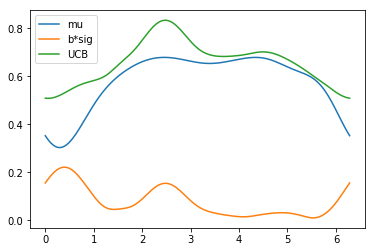

In [27]:
def plot_reference(m,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    mus = []
    var = []
    tot = []
    for a in actions:
        out = opt.integrate(m,p.angle_delta_np(s,a),B)
        mus.append(out[0])
        var.append(2.0*np.sqrt(out[1]))
        tot.append(out[0] + 2.0*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
plot_reference(gps[3],np.array([20.0,20.0]))

def plot_error(gp,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    preds = np.array([])
    for a in actions:
        preds = np.append(preds,opt.integrate_dim(gp, 2, a, p.angle_delta_np(s,a),B)[0])
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, preds,label='gp')
    plt.show()
# plot_error(gps[-1],np.array([17.0,17.0]))

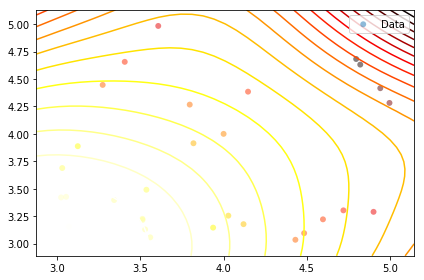

In [49]:
gps[-1].plot()

In [16]:
GPS = []
def VI():
    D = {}
    for (x, y) in p.supports:
        if p.in_obstacle(x, y):
            D[(x, y)] = 0.0
        else:
            D[(x, y)] = 10.0 * 0.9 ** p.norm(p.goalX, p.goalY, x, y)
    D[(p.goalX, p.goalY)] = 10.0
    VGP, _, _ = p.GPFromDict(D)
    GPS.append(VGP)
    VGP = GPS[-1]
    for i in range(30):
        for (x, y) in p.supports:
            if abs(x-3) + abs(y-3) > i:
                continue
            s = np.array([[x,y]])
            gp = GPy.models.GPRegression(s, VGP.predict(s)[0], GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
            maxa, value = q_estimate2(VGP,gp,s[0,:])
            print s, maxa, value
            D[(x,y)] = value
        VGP, _,_ = p.GPFromDict(D)
        GPS.append(VGP)
VI()


[[3.31578947 3.31578947]] 3.377868424194039 46.40494840522297
[[2.21052632 2.21052632]] 0.7875859020141542 14.664532989207942
[[2.21052632 3.31578947]] 0.33253626973930955 16.1963900088449
[[3.31578947 2.21052632]] 4.44548486914656 29.9562746421434
[[3.31578947 3.31578947]] 4.830526865686813 16.379028615308926
[[3.31578947 4.42105263]] 4.760519229952221 17.128107273520982
[[4.42105263 3.31578947]] 3.097837881255673 17.124726967143744
[[1.10526316 2.21052632]] 0.1750190893364787 11.572989920389773
[[1.10526316 3.31578947]] 5.968150946373924 11.206855365767069
[[2.21052632 1.10526316]] 0.9626049913506329 13.43260820675232
[[2.21052632 2.21052632]] 0.31503436080566166 15.370289472896758
[[2.21052632 3.31578947]] 3.4653779688622786 17.37904251134023
[[2.21052632 4.42105263]] 5.390587951563544 12.43013844744599
[[3.31578947 1.10526316]] 1.6626813486965477 14.658983848374646
[[3.31578947 2.21052632]] 5.460595587298136 19.542765608355694
[[3.31578947 3.31578947]] 4.585500140615742 16.59991662

[[6.63157895 4.42105263]] 3.902925692203475 7.994639734723933
[[7.73684211 2.21052632]] 2.852811156184603 6.957215653576511
[[7.73684211 3.31578947]] 3.255355061658504 7.198462877567636
[[0. 0.]] 1.627677530829252 44.61593753588386
[[0.         1.10526316]] 3.010328336587434 32.79045811435208
[[0.         2.21052632]] 4.620503958483038 44.90051725416561
[[0.         3.31578947]] 4.725515412084925 22.45279204729013
[[0.         4.42105263]] 5.793131857037445 10.684663827065378
[[0.         5.52631579]] 5.250572680094361 9.993139948725002
[[0.         6.63157895]] 5.198066953293417 8.390654649934731
[[1.10526316 0.        ]] 2.345255797108815 35.60311553331849
[[1.10526316 1.10526316]] 3.132841699122969 43.589485196727736
[[1.10526316 2.21052632]] 3.8854237832698275 36.39990755271083
[[1.10526316 3.31578947]] 0.4375477233411968 11.98854357221262
[[1.10526316 4.42105263]] 5.705622312369206 11.969170172749727
[[1.10526316 5.52631579]] 4.830526865686813 11.271409070874824
[[1.10526316 6.631

[[8.84210526 3.31578947]] 3.2028493348575604 5.945289036194481
[[8.84210526 4.42105263]] 3.7104046939333486 5.426773860686808
[[9.94736842 2.21052632]] 2.852811156184603 4.726518689006298
[[9.94736842 3.31578947]] 3.2028493348575604 4.882299643999886
[[0. 0.]] 0.8400916288150978 27.737868779948258
[[0.         1.10526316]] 0.28003054293836593 29.512418284830346
[[0.         2.21052632]] 5.898143310639332 28.590258389129303
[[0.         3.31578947]] 5.285576497961657 25.827813176652853
[[0.         4.42105263]] 4.953040228222347 22.033665485989786
[[0.         5.52631579]] 5.215568862227066 12.294781299609895
[[0.         6.63157895]] 2.8178073383173072 8.258857432868353
[[0.         7.73684211]] 5.443093678364487 6.093613426973661
[[0.         8.84210526]] 4.988044046089644 4.7375070258567575
[[1.10526316 0.        ]] 1.8552023469666743 28.226911429839674
[[1.10526316 1.10526316]] 2.012719527369505 27.76313546716483
[[1.10526316 2.21052632]] 4.44548486914656 28.897387091803466
[[1.1052

[[3.31578947 8.84210526]] 4.5504963227484465 5.974729348434266
[[3.31578947 9.94736842]] 4.567998231682094 4.786821679120976
[[ 3.31578947 11.05263158]] 4.673009685283981 3.9684689306807286
[[ 3.31578947 12.15789474]] 4.813024956753164 3.5102609701317533
[[4.42105263 0.        ]] 2.677792066848124 15.382852962193283
[[4.42105263 1.10526316]] 3.0803359723220254 17.488681820680114
[[4.42105263 2.21052632]] 2.5377767953789414 20.391529609872578
[[4.42105263 3.31578947]] 3.1853474259239123 22.105352021980252
[[4.42105263 4.42105263]] 3.8679218743361794 19.67202551310038
[[4.42105263 5.52631579]] 4.077944781539954 12.833123109070584
[[4.42105263 6.63157895]] 4.44548486914656 9.750266837072559


KeyboardInterrupt: 

In [20]:
VGP = GPS[-1]
path = []
x,y = 17.0,17.0
reachedGoal = False
for _ in range(50):
    print x,y
    path.append((x,y))
    s = np.array([[x,y]])
    gp = GPy.models.GPRegression(s, VGP.predict(s)[0], GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
    maxa, _ = q_estimate2(VGP,gp,s[0,:])
    (nx, ny),_ = p.transition(x,y,maxa)
    if not reachedGoal and p.in_goal(nx,ny):
        print "REACHED IN %d" % (i)
        reachedGoal=True
    x,y = nx,ny


17.0 17.0
15.92404458233766 16.44731079945481
15.080095119740076 15.965794371202916
14.179267317989991 15.709675198338315
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0
13.9429040944 15.0


KeyboardInterrupt: 

In [68]:
print VGP.predict(np.array([[20.0,20.0]]))

(array([[0.78783389]]), array([[1.14793316]]))


(array([[283.34022114]]), array([[1.35386346]]))
(array([[-3.98383032]]), array([[1.14793316]]))


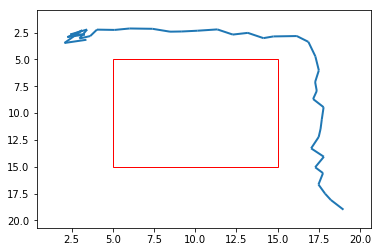

In [8]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.patches as patches
lines = []
for i in xrange(len(path)-1):
    lines.append([path[i],path[i+1]])

obstacles = []
for obs in p.obstacles:
    rec = patches.Rectangle((obs.bounds[0],obs.bounds[1]),obs.bounds[2]-obs.bounds[0],obs.bounds[3]-obs.bounds[1],linewidth=1,edgecolor='r',facecolor='none')
    obstacles.append(rec)


lc = mc.LineCollection(lines,linewidths=2)
fig, ax = pl.subplots()
# pl.plot([i[0] for i in path], [i[1] for i in path], 'ro')
for rec in obstacles:
    ax.add_patch(rec)

ax.add_collection(lc)
ax.autoscale()
ax.invert_yaxis()
ax.margins(0.1)